# CartPole Reinforcement Learning Report
---

## Important Information
Without CUDA some of the code takes extremely long to run. The current report contains the output of the full run(training and hyperparameter tuning). For the sake of faster runs, for subsequent executions of this report, the trained weights and Q-tables are loaded, with training codes commented out. 

---

## Table Of Contents
---

### 1. Introduction 
#### $~~~~~$ 1.1 Action Space
#### $~~~~~$ 1.2 State Space
#### $~~~~~$ 1.3 Success Criteria
### 2. Methods
#### $~~~~~$ 2.0 Shared Foundations in Reinforcement Learning
#### $~~~~~~~~~~$ 2.0.1 State Space Discretization (for Monte Carlo and Q-Learning)
#### $~~~~~~~~~~$ 2.0.2 Epsilon-Greedy Policy
#### $~~~~~~~~~~$ 2.0.3 Agent Evaluation
#### $~~~~~$ 2.1 Monte Carlo
#### $~~~~~$ 2.2 Q-Learning
#### $~~~~~~~~~~$ 2.2.1 Core Concepts
#### $~~~~~~~~~~$ 2.2.2 Implementation Details
#### $~~~~~~~~~~$ 2.2.3 Training Procedure
#### $~~~~~~~~~~$ 2.2.4 Evaluation and Plot Functions
#### $~~~~~~~~~~$ 2.2.5 Hyperparameter Tuning
#### $~~~~~~~~~~$ 2.2.6 Agent Evaluation
#### $~~~~~$ 2.3 Deep-Q Network (DQN)
#### $~~~~~~~~~~$ 2.3.1 Key Components
#### $~~~~~~~~~~$ 2.3.2 Training Notes|
#### $~~~~~~~~~~$ 2.3.3 Key Equations
#### $~~~~~~~~~~$ 2.3.4 Defining the Double DQN Agent
#### $~~~~~~~~~~$ 2.3.5 Agent Evaluation
### 3. Rendering an Episode


---

# 1. Introduction
In this project, three Reinforcement Learning (RL) algorithms - Monte Carlo, Q-Learning, and Deep Q Network (DQN), are implemented to solve the CartPole-v1 problem, and their performance and metrics are studied and compared.

The CartPole environment consists of a cart moving on a frictionless track with a pole attached by an unactuated joint. The objective is to balance the pole by applying force left (0) or right (1) on the cart. The agent learns by interacting with the environment, receiving rewards for keeping the pole balanced and penalties for failure.

## 1.1 Action Space
The action is an ndarray with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

## 1.2 State Space
We define observation as a state (they are used interchangeably here). The observation is an ndarray with shape (4,) with the values corresponding to the following positions and velocities:

| Observation[n] | Observation       | Min             | Max           |
| ------- | --------------------- | ------------------- | ----------------- |
| 0   | Cart Position         | \-4.8               | 4.8               |
| 1   | Cart Velocity         | \-Inf               | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | \-Inf               | Inf               |

## 1.3 Success Criteria
The challenge is to balance the pole for 500 states per episode.

The pole is said to be balanced if:

Pole Angle is at most ±12°
Cart Position is at most ±2.4 (center of the cart reaches the edge of the display)
Violation to any of the above two conditions defines an unbalanced pole.

# 2. Methods
We implemented and compared three RL approaches:
1. Monte Carlo
2. Q-Learning
3. DQN

## 2.0 Shared Foundations in Reinforcement Learning

Both Monte Carlo, Q-Learning, and Deep Q-Network (DQN) agents for the CartPole environment share foundational components essential for learning in continuous state spaces. This section outlines the core building blocks common across methods.

### 2.0.1 State Space Discretization

The CartPole environment outputs continuous observations for cart position, velocity, pole angle, and angular velocity. To apply tabular methods (Monte Carlo and Q-Learning):

- Define bounds for each feature.
- Normalize values to a [0,1] range.
- Map normalized values into discrete bins.
- Clip to ensure valid ranges.

> Note:  
> DQN, in contrast, avoids discretization by learning directly from continuous values via a neural network.

### 2.0.2 Epsilon-Greedy Policy

To balance exploration and exploitation:

- With probability ε, the agent takes a random action.
- Otherwise, it selects the best-known action.
- ε decays over time to promote exploitation.

This strategy is shared across all agents to improve learning efficiency.

### 2.0.3 Agent Evaluation

During evaluation:

- ε is set to 0.0 to disable exploration.
- Multiple episodes are run using the learned policy.
- Average total reward is computed to assess performance.


## Importing of Dependencies

In [10]:
# Standard libraries
import os
import sys
import glob
import math
import time
import random
import itertools
import pickle
import io
import base64
import logging
import collections
from collections import deque, defaultdict
from multiprocessing import Pool
from typing import List, Tuple, Dict, Union

# Numerical and data processing
import numpy as np
import pandas as pd
import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import display as ipythondisplay, HTML
import pygame

# Gym and Reinforcement Learning
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo

# Configure gym logging level
gymlogger.set_level(40)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

print("All necessary libraries have been imported and configured.")

pygame 2.6.1 (SDL 2.28.4, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
All necessary libraries have been imported and configured.


## 2.1 Monte Carlo

Monte Carlo learning is a model-free reinforcement learning approach that updates Q-values using first-visit state-action pairs. Unlike dynamic programming, it doesn't require a model of the environment. For CartPole, this method is applied after discretizing the continuous state space as described in Section 2.1.

### Core Idea

The algorithm learns Q-values by averaging the total return received after the first visit to each state-action pair in an episode. This episodic method ensures that updates reflect the long-term outcome of actions taken in specific states.

### Key Implementation Details

1. Use of Discretized State Space:
   - As detailed in Section 2.1.1, the continuous state space is discretized to allow for tabular learning.
   - This enables mapping observations to discrete indices usable in Q-tables.

2. Policy for Action Selection:
   - The ε-greedy strategy (Section 2.1.2) governs action choice during training, enabling both exploration and exploitation.
   - ε decays over time to encourage convergence toward an optimal policy.

3. Training Algorithm (First-Visit Monte Carlo Control):
   - For each training episode:
     - Generate a full episode using the ε-greedy policy.
     - Identify the first occurrence of each state-action pair.
     - Calculate the total return from that point onward.
     - Update the Q-value using the incremental average of returns.
     - Decay ε to reduce exploration in future episodes.

4. Evaluation:
   - As described in Section 2.1.3, evaluation is performed with ε = 0.0 over multiple episodes to assess learned policy performance.

---

This method enables learning from complete episodes, making it suitable when the model is unknown and trajectories are finite, like in CartPole.


MC does not take long to train, but the current code loads the best Q-Table from past training. Uncomment the training code to execute training

Training with 4 bins per dimension...
Average reward with 4 bins: 372.2
Training with 6 bins per dimension...
Average reward with 6 bins: 101.35
Training with 8 bins per dimension...
Average reward with 8 bins: 455.07
Training with 10 bins per dimension...
Average reward with 10 bins: 460.16
Training with 12 bins per dimension...
Average reward with 12 bins: 478.81
Training with 16 bins per dimension...
Average reward with 16 bins: 451.64
Training with 20 bins per dimension...
Average reward with 20 bins: 438.93


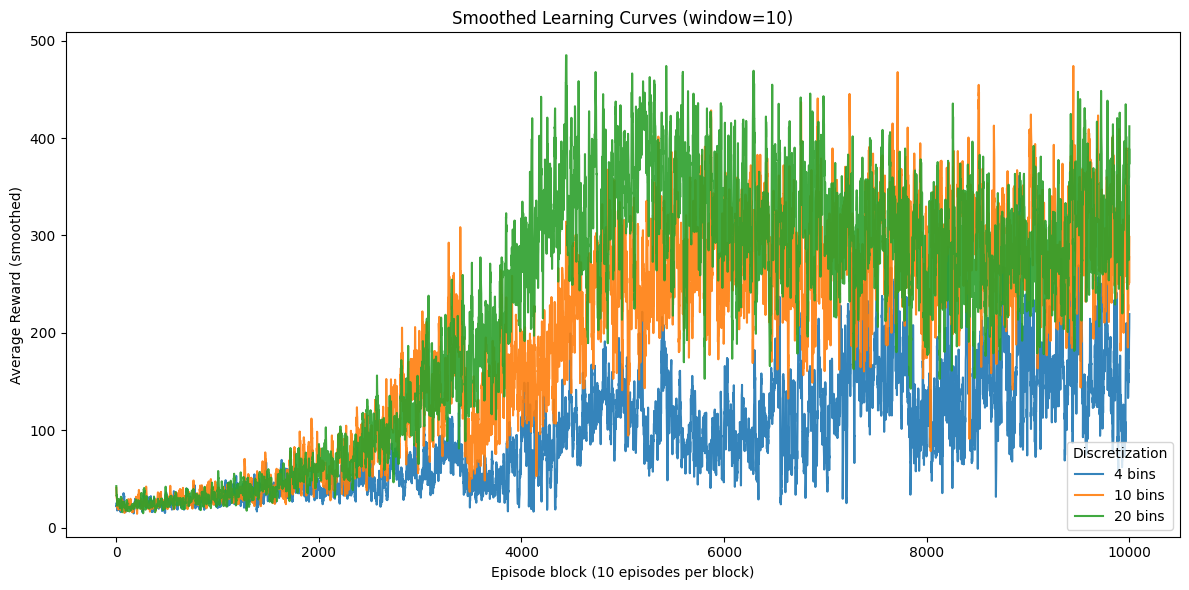

In [ ]:
def create_bins(low, high, num_bins):
    """Create bins for a continuous variable."""
    return np.linspace(low, high, num_bins + 1)[1:-1]

def discretize_state(state, bins):
    """Discretize a continuous state into discrete indices."""
    state = np.array(state)
    state[0] = np.clip(state[0], -4.8, 4.8)     # Cart Position
    state[1] = np.clip(state[1], -3.0, 3.0)      # Cart Velocity
    state[2] = np.clip(state[2], -0.418, 0.418)   # Pole Angle
    state[3] = np.clip(state[3], -3.5, 3.5)       # Pole Angular Velocity
    return tuple(np.digitize(state[i], bins[i]) for i in range(len(state)))

def epsilon_greedy_policy(state, Q, epsilon, nA=2):
    """Select an action using an ε-greedy policy."""
    if state not in Q:
        Q[state] = np.zeros(nA)
    return np.random.choice(nA) if np.random.rand() < epsilon else np.argmax(Q[state])

def zeros_array():
    return np.zeros(2)

def zeros_array_returns():
    return np.zeros(2)
    
def plot_smoothed_learning_curves(learning_curves, window=5, 
                                  levels_to_plot=None, alpha=0.8):
    """
    learning_curves: dict {num_bins: [avg_reward_block1, block2, ...]}
    window: int, rolling window size in blocks
    levels_to_plot: list of num_bins to include (or None for all)
    alpha: line transparency
    """
    plt.figure(figsize=(12, 6))
    
    # pick only a few levels if requested
    keys = sorted(learning_curves.keys())
    if levels_to_plot is not None:
        keys = [k for k in keys if k in levels_to_plot]
    
    for num_bins in keys:
        rewards = np.array(learning_curves[num_bins])
        # smooth with rolling mean
        df = pd.Series(rewards)
        smooth = df.rolling(window, min_periods=1, center=True).mean().values
        
        blocks = np.arange(1, len(smooth) + 1)
        plt.plot(blocks, smooth, label=f"{num_bins} bins", alpha=alpha)
    
    plt.xlabel("Episode block (10 episodes per block)")
    plt.ylabel("Average Reward (smoothed)")
    plt.title(f"Smoothed Learning Curves (window={window})")
    plt.legend(title="Discretization", loc="lower right")
    plt.tight_layout()
    plt.show()

num_training_episodes = 10000
gamma = 1.0
evaluation_episodes = 100

# Different discretization levels (number of buckets per state dimension) to compare:
discretization_levels = [4, 6, 8, 10, 12, 16, 20]

# Dictionaries to store average evaluation rewards and learning curves
average_rewards = {}
learning_curves = {}

header = "========================================"
print(header)

for num_bins in discretization_levels:
    print(f"Training with {num_bins} bins per dimension...")
    
    # Create bins for each state dimension
    pos_bins = create_bins(-4.8, 4.8, num_bins)
    vel_bins = create_bins(-3.0, 3.0, num_bins)
    angle_bins = create_bins(-0.418, 0.418, num_bins)
    ang_vel_bins = create_bins(-3.5, 3.5, num_bins)
    bins = [pos_bins, vel_bins, angle_bins, ang_vel_bins]
    
    env = gym.make('CartPole-v1')
    Q = defaultdict(zeros_array)
    returns_count = defaultdict(zeros_array_returns)
    episode_rewards = []

    try:
        with open(f"checkpoints/trained_q_table_mc_{num_bins}.pkl", "rb") as f:
            Q = pickle.load(f)
        print(f" Q-table for {num_bins} bins loaded successfully!")
    except FileNotFoundError:
        print(f"No pre-trained Q-table for {num_bins} bins found. Proceeding with training.")
    

    # ###### TRAINING START (UNCOMMENT TO TRAIN) #######
    # # Use a decay schedule for epsilon that decays to 0.1 over the first half of the training episodes
    # min_epsilon = 0.1
    # epsilon_decay_rate = (1.0 - min_epsilon) / (num_training_episodes / 2)
    
    # for i_episode in range(num_training_episodes):
    #     epsilon = max(min_epsilon, 1.0 - i_episode * epsilon_decay_rate)
    #     state, _ = env.reset()
    #     discrete_state = discretize_state(state, bins)
    #     done = False
    #     episode = []
        
    #     while not done:
    #         action = epsilon_greedy_policy(discrete_state, Q, epsilon)
    #         next_state, reward, terminated, truncated, _ = env.step(action)
    #         done = terminated or truncated
    #         episode.append((discrete_state, action, reward))
    #         discrete_state = discretize_state(next_state, bins)
        
    #     # Monte Carlo First-Visit Update
    #     G = 0
    #     visited = set()
    #     for t in reversed(range(len(episode))):
    #         s, a, r = episode[t]
    #         G = r + gamma * G  # Here gamma=1.0, so G is simply the sum of rewards
    #         if (s, a) not in visited:
    #             visited.add((s, a))
    #             returns_count[s][a] += 1
    #             Q[s][a] += (G - Q[s][a]) / returns_count[s][a]
    #     episode_rewards.append(sum(r for (_, _, r) in episode))
    
    # env.close()
    
    # # Save the trained Q-table (weights) for this discretization level
    # with open(f"trained_q_table_mc_{num_bins}.pkl", "wb") as f:
    #     pickle.dump(Q, f)

    # ###### TRAINING END #######
    
    learning_curves[num_bins] = episode_rewards
    
    # Evaluation
    env = gym.make('CartPole-v1')
    eval_rewards = []
    for i in range(evaluation_episodes):
        state, _ = env.reset()
        discrete_state = discretize_state(state, bins)
        total_reward = 0
        done = False
        while not done:
            action = np.argmax(Q[discrete_state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            discrete_state = discretize_state(state, bins)
        eval_rewards.append(total_reward)
    env.close()
    
    avg_reward = np.mean(eval_rewards)
    average_rewards[num_bins] = avg_reward
    print(f"Average reward with {num_bins} bins: {avg_reward}")
    print(header)

plot_smoothed_learning_curves(
    learning_curves,
    window=10,
    levels_to_plot=[4, 10, 20],
    alpha=0.9
)

MC peforms better with higher levels of discretisation since the environment has a continuous state space and discretisation reduces approximation error and bias by more accurately representing the underlying state dynamics and improves policy evaluation due to more precise estimations and enhanced sensitivity.

## 2.2 Q-Learning

Q-Learning is an off-policy, model-free reinforcement learning algorithm that learns optimal action-selection by updating Q-values using the Bellman equation. Unlike Monte Carlo, it updates after every step instead of waiting for an entire episode. For CartPole, the algorithm is applied after state discretization (see Section 2.1.1).

### 2.2.1 Core Concepts

- Q-Table: A 2D array storing Q-values for each discretized state-action pair.
- Bellman Update Rule:
  $$
  Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha \left( r + \gamma \max_a Q(s', a) \right)
  $$

- Exploration-Exploitation: Handled using the shared ε-greedy strategy (Section 2.1.2).
- Immediate Updates: Updates Q-values after every step, allowing faster convergence than episodic methods.

---

- Step-based updates make Q-Learning more responsive than Monte Carlo.  
- Combines discretization and Bellman updates for efficient learning.  
- Exploration decay helps transition from learning to optimal performance.  
- Model saving allows training continuation and real-world deployment.


### 2.2.2 Implementation Details

#### Hyperparameters
- `alpha` (learning rate): Controls the influence of new knowledge.
- `gamma` (discount factor): Weighs future vs immediate rewards.
- `epsilon` & `epsilon_decay`: Manage exploration vs exploitation.
- `alpha_min`: Sets a floor for learning rate to avoid stagnation.
- `bins`: Controls state discretization resolution.

#### Q-Table Initialization
The Q-table is initialized to zero for all state-action pairs. The table’s size is determined by the discretized state dimensions and the number of available actions.

#### Decay Strategies
- `epsilon` decays multiplicatively each episode to shift from exploration to exploitation.
- `alpha` decays gradually to stabilize learning over time.

In [ ]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, 
                    epsilon_decay=0.995, alpha_min=0.01, bins=(16, 16, 16, 16)):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha_min = alpha_min
        self.bins = bins

        self.q_table = np.zeros(self.bins + (self.env.action_space.n,))

        self.obs_space_low = self.env.observation_space.low
        self.obs_space_high = self.env.observation_space.high
        self.obs_space_high[1] = 5
        self.obs_space_high[3] = np.radians(50)
        self.obs_space_low[1] = -5
        self.obs_space_low[3] = -np.radians(50)

    def discretize(self, obs):
        ratios = [(obs[i] - self.obs_space_low[i]) / (self.obs_space_high[i] - self.obs_space_low[i])
                    for i in range(len(obs))]
        new_obs = [int(round((self.bins[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(self.bins[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state, done):
        future_q = np.max(self.q_table[next_state]) if not done else 0
        self.q_table[state][action] += self.alpha * (reward + self.gamma * future_q - self.q_table[state][action])

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def decay_learning_rate(self):
        if self.alpha > self.alpha_min:
            self.alpha *= 0.99995

    def save_q_table(self, filename="trained_q_table.pkl"):
        with open(filename, "wb") as f:
            pickle.dump(self.q_table, f)
        print("Q-table saved successfully!")

    def load_q_table(self, filename="trained_q_table.pkl"):
        with open(filename, "rb") as f:
            self.q_table = pickle.load(f)
        print("Q-table loaded successfully!")

### 2.2.3 Training Procedure

1. Reset environment for each episode.
2. Discretize state and select action using the ε-greedy policy.
3. Take action → observe next state, reward, and done flag.
4. Update Q-table using the Bellman equation.
5. Repeat until episode ends.
6. Decay `epsilon` and `alpha` after each episode.

In [19]:
def train_agent(agent, episodes=5000):
    rewards = []
    avg_rewards = []
    
    for episode in range(episodes):
        state = agent.discretize(agent.env.reset()[0])
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = agent.env.step(action)
            done = terminated or truncated
            next_state = agent.discretize(next_state)
            agent.update_q_table(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        agent.decay_epsilon()
        agent.decay_learning_rate()
        rewards.append(total_reward)

        # Average reward every 100 episodes
        if (episode + 1) % 10 == 0:
            avg_rewards.append(np.mean(rewards[-100:]))

    return rewards, avg_rewards

### 2.2.4 Evaluation and Plot Functions

Follows the standard evaluation process (see Section 2.1.3):

- Set `epsilon = 0.0` for pure exploitation.
- Run multiple test episodes.
- Track total and average rewards to assess performance.

In [21]:
def q_evaluate_agent(agent, episodes=100, prints = 0):
    total_rewards = []
    agent.epsilon = 0.0
    header = "============================================="
    for i in range(episodes):
        current_state = agent.discretize(agent.env.reset()[0])
        total_reward = 0
        done = False
        while not done:
            action = np.argmax(agent.q_table[current_state])
            next_state, reward, terminated, truncated, _ = agent.env.step(action)
            done = terminated or truncated
            current_state = agent.discretize(next_state)
            total_reward += reward
        total_rewards.append(total_reward)
        if prints == 1:
            print(f"Evaluation Episode {i+1}/{episodes} -> Reward: {total_reward}")

    return total_rewards

Simple plot function

In [23]:
def plot_rewards(avg_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(avg_rewards, label='Average Reward per 100 Episodes', color='b')
    plt.xlabel('Episode (Hundreds)')
    plt.ylabel('Average Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.grid()
    plt.show()

### 2.2.5 Hyperparameter Tuning

To improve performance:

1. Use grid search over values of `alpha`, `gamma`, `epsilon_decay`, and `bins`.
2. Train multiple agents with different configurations.
3. Evaluate each on a fixed set of test episodes.
4. Select the model with the highest and most stable average rewards.

In [25]:
def experiment_qlearning(params_list, episodes=1000, eval_episodes=20):
    """
    Runs multiple Q-learning experiments, selects the best model, 
    and displays training progress with a single graph and results in a table.

    Args:
        params_list (list of dicts): List of parameter dictionaries.
        episodes (int): Number of training episodes.
        eval_episodes (int): Number of evaluation episodes.

    Returns:
        dict: Best model's parameters and evaluation score.
    """
    best_model = None
    best_score = -float("inf")
    best_params = None
    all_results = []
    all_rewards = []

    total_experiments = len(params_list)
    running_index = 0
    header = "==================================================================================================================================="
    divider = "-----------------------------------------------------------------------------------------------------------------------------------"

    for i, params in enumerate(params_list):

        env = gym.make("CartPole-v1")
        print(f"Running Experiment {i+1} with Parameters: {params}")
        print(divider)

        params.setdefault("bins", (6, 12, 6, 12))

        agent = QLearningAgent(env, 
                               alpha=params.get('alpha', 0.1),
                               gamma=params.get('gamma', 0.99),
                               epsilon=params.get('epsilon', 1),
                               epsilon_decay=params.get('epsilon_decay', 0.995),
                               bins=params.get('bins'),
                               alpha_min=params.get('alpha_min', 0.01))

        rewards, avg_rewards = train_agent(agent, episodes=episodes)
        all_rewards.append((i+1, avg_rewards))

        print(f"Evaluating Experiment {i+1}...")
        print(divider)
        eval_rewards = q_evaluate_agent(agent, episodes=eval_episodes, prints=0)
        avg_eval_reward = np.mean(eval_rewards)

        print(f"Exp {i+1} Completed with Evaluation Avg: {avg_eval_reward:.2f}")
        print(header)

        all_results.append({
            "Experiment": i+1,
            "Alpha": params["alpha"],
            "Gamma": params["gamma"],
            "Epsilon Decay": params["epsilon_decay"],
            "Bins": params["bins"],
            "Avg Evaluation Reward": avg_eval_reward
        })

        if avg_eval_reward > best_score:
            best_score = avg_eval_reward
            best_model = agent
            best_params = params

        env.close()
        time.sleep(0.1)

    sys.stdout.write("\n")

    # Create a plot for all experiments
    plt.figure(figsize=(12, 6))
    for exp_id, rewards in all_rewards:
        sns.lineplot(x=np.arange(len(rewards)), y=rewards, label=f'Exp {exp_id}')
    plt.xlabel("Episodes (hundreds)")
    plt.ylabel("Rewards")
    plt.title("Training Progress Across Experiments")
    plt.legend(loc='best', ncol=2)
    plt.show()

    results_df = pd.DataFrame(all_results)
    print("\nExperiment Results:")
    print(results_df.to_string(index=False))

    print("\nBest Model Selected:")
    print(f"Parameters: {best_params}")
    print(f"Best Evaluation Reward: {best_score:.2f}")

    return {"best_model": best_model, "best_params": best_params, "best_score": best_score}

Below is the execution of hyperparameter tuning for Q-Learning. This cell can be skipped if the Q-table is already loaded in

==================================================== Total parameter sets: 24 =====================================================
Running Experiment 1 with Parameters: {'alpha': 0.05, 'gamma': 0.95, 'epsilon': 1.0, 'epsilon_decay': 0.98, 'bins': (16, 16, 16, 16)}
-----------------------------------------------------------------------------------------------------------------------------------
Evaluating Experiment 1...
-----------------------------------------------------------------------------------------------------------------------------------
Exp 1 Completed with Evaluation Avg: 20.87
Running Experiment 2 with Parameters: {'alpha': 0.05, 'gamma': 0.95, 'epsilon': 1.0, 'epsilon_decay': 0.98, 'bins': (20, 20, 20, 20)}
-----------------------------------------------------------------------------------------------------------------------------------
Evaluating Experiment 2...
-----------------------------------------------------------------------------------------------------------

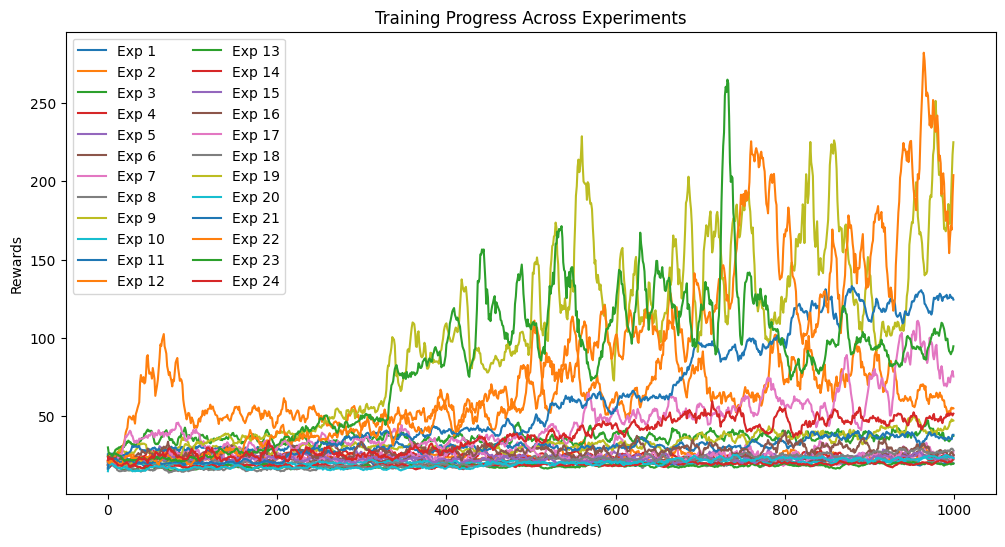


Experiment Results:
 Experiment  Alpha  Gamma  Epsilon Decay             Bins  Avg Evaluation Reward
          1   0.05   0.95           0.98 (16, 16, 16, 16)                 20.870
          2   0.05   0.95           0.98 (20, 20, 20, 20)                 24.235
          3   0.05   0.95           0.99 (16, 16, 16, 16)                 34.265
          4   0.05   0.95           0.99 (20, 20, 20, 20)                 24.550
          5   0.05   0.99           0.98 (16, 16, 16, 16)                 25.230
          6   0.05   0.99           0.98 (20, 20, 20, 20)                 26.965
          7   0.05   0.99           0.99 (16, 16, 16, 16)                 28.945
          8   0.05   0.99           0.99 (20, 20, 20, 20)                 19.735
          9   0.10   0.95           0.98 (16, 16, 16, 16)                 43.270
         10   0.10   0.95           0.98 (20, 20, 20, 20)                 22.665
         11   0.10   0.95           0.99 (16, 16, 16, 16)                 39.345
       

In [27]:
alpha_values = [0.05, 0.1, 0.2]
gamma_values = [0.95, 0.99]
epsilon_decay_values = [0.98, 0.99]
bins_values = [(16, 16, 16, 16), (20, 20, 20, 20)]

param_sets = [
    {'alpha': alpha, 'gamma': gamma, 'epsilon': 1.0, 'epsilon_decay': epsilon_decay, 'bins': bins}
    for alpha, gamma, epsilon_decay, bins in itertools.product(alpha_values, gamma_values, epsilon_decay_values, bins_values)
]

print(f"==================================================== Total parameter sets: {len(param_sets)} =====================================================")

best_model_info = experiment_qlearning(param_sets, episodes=10000, eval_episodes=200)

if best_model_info:
    best_params = best_model_info.get("best_params", {})
    best_score = best_model_info.get("best_score", "N/A")
    print(f"\nBest hyperparameters found: {best_params}")
    print(f"Best hyperparameter evaluation score: {best_score:.2f}")
else:
    logging.warning("No successful experiments were completed.")

### 2.2.6 Agent Evaluation

1. Save the learned Q-table for future reuse.
2. Load a saved table to resume training or perform evaluation without retraining.

Actual training is commented out, Q-tables are being loaded into the agent

Training agent with best hyperparameters...


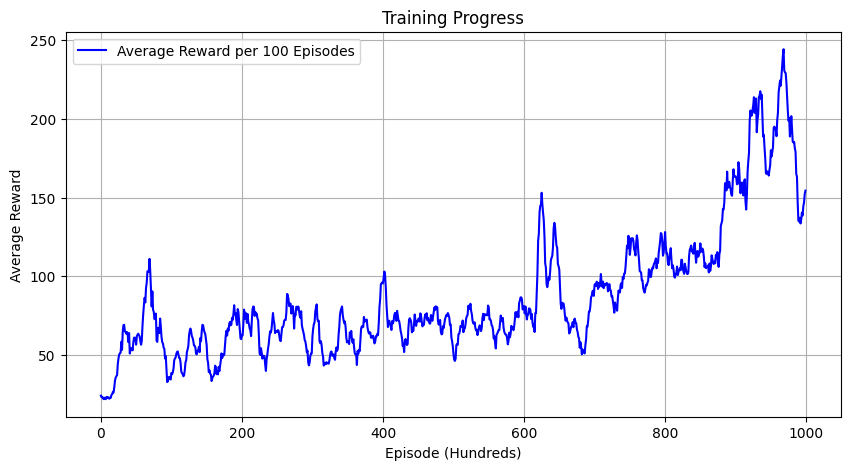

Q-table saved successfully!
Evaluating agent with best hyperparameters...
Evaluation Episode 1/200 -> Reward: 12.0
Evaluation Episode 2/200 -> Reward: 308.0
Evaluation Episode 3/200 -> Reward: 133.0
Evaluation Episode 4/200 -> Reward: 82.0
Evaluation Episode 5/200 -> Reward: 164.0
Evaluation Episode 6/200 -> Reward: 168.0
Evaluation Episode 7/200 -> Reward: 153.0
Evaluation Episode 8/200 -> Reward: 26.0
Evaluation Episode 9/200 -> Reward: 148.0
Evaluation Episode 10/200 -> Reward: 181.0
Evaluation Episode 11/200 -> Reward: 79.0
Evaluation Episode 12/200 -> Reward: 217.0
Evaluation Episode 13/200 -> Reward: 159.0
Evaluation Episode 14/200 -> Reward: 278.0
Evaluation Episode 15/200 -> Reward: 274.0
Evaluation Episode 16/200 -> Reward: 154.0
Evaluation Episode 17/200 -> Reward: 152.0
Evaluation Episode 18/200 -> Reward: 165.0
Evaluation Episode 19/200 -> Reward: 163.0
Evaluation Episode 20/200 -> Reward: 242.0
Evaluation Episode 21/200 -> Reward: 109.0
Evaluation Episode 22/200 -> Reward:

In [ ]:
env = gym.make('CartPole-v1')
rewards, avg_rewards = ([], [])
q_agent = QLearningAgent(env,
                        alpha=best_params.get('alpha'),
                        gamma=best_params.get('gamma'),
                        epsilon=best_params.get('epsilon'),
                        epsilon_decay=best_params.get('epsilon_decay'),
                        bins=best_params.get('bins'))
q_agent.load_q_table("checkpoints/trained_q_table.pkl")
# print("Training agent with best hyperparameters...")
# rewards, avg_rewards = train_agent(q_agent, episodes=10000) # with training
# plot_rewards(avg_rewards) # with training
# q_agent.save_q_table("trained_q_table.pkl")
print("Evaluating agent with best hyperparameters...")
evaluation_rewards = q_evaluate_agent(q_agent, episodes=200, prints=1)
print(f"Mean evaluation reward: {np.mean(evaluation_rewards):.2f}")

The Q-Learning training is shown to be unstable since due to a combination of bootstrapping from coarse discretisation, max‑operator overestimation, data scarcity per state and ε‑greedy schedule too slow to freeze.

## 2.3 Deep Q-Network (DQN)

Given that CartPole features a continuous state space (cart position, velocity, pole angle, and angular velocity) and a small discrete action space (left or right), we can opt to adopt a Deep Q-Network (DQN) approach. Unlike classical Q-learning that requires state discretization, DQN learns directly from continuous states via a neural network.

We use a Double DQN variant to improve learning stability and mitigate overestimation of Q-values.

---

### 2.3.1 Key Components

#### Neural Network Architecture
- Input: 4 state values (Cart Position, Velocity, Pole Angle, Angular Velocity)
- Hidden Layers: 2 fully connected layers with ReLU activation functions
- Output: 2 Q-values (Left/Right)

#### Experience Replay
- Stores past experiences as tuples: (state, action, reward, next_state, done)
- Random mini-batches are sampled during training to break temporal correlations and stabilize learning

#### Target Network
- A separate network is used to generate target Q-values
- Updated only at fixed intervals (or softly), reducing oscillations and divergence from frequent parameter updates

#### Loss Function
- Mean Squared Error (MSE) between predicted and target Q-values
- Gradient descent updates are applied using optimizers like Adam

---

### 2.3.2 Training Notes

- The neural network is kept small: 2 hidden layers with 64 neurons each
- A higher discount factor (γ) encourages long-term reward consideration, despite slightly increasing training volatility
- Stability is enhanced through:
  - Double DQN updates
  - Lower learning rates
  - Slower epsilon decay
  - Replay delay
  - Rolling average of rewards using a fixed-size window (e.g., 3 episodes)

---

### 2.3.3 Key Equations

#### Target Q-Value Equation (Double DQN)
$$
Y_t^{\text{DoubleQ}} \equiv R_{t+1} + \gamma Q(S_{t+1}, \arg\max\limits_{a} Q(S_{t+1}, a; \theta_t); \theta_t')
$$

- θ: parameters of the online (current) network
- θ': parameters of the target network

This separates action selection (online network) from evaluation (target network), reducing overestimation bias.

#### Loss Function in Double DQN

$$
L(\theta) = \mathbb{E}_{(s,a,r,s') \sim D} \left[ \left(y^{\text{Double DQN}} - Q(s, a; \theta) \right)^2 \right]
$$

- D : replay buffer
- y<sup>Double DQN</sup>: target value

The loss drives gradient updates that train the online network to better approximate expected returns.

---

### 2.3.4 Defining the Double DQN Agent

The Double DQN agent combines all the components above into a system that:
- Learns directly from continuous observations
- Utilizes two networks (online and target) for stable Q-learning
- Leverages experience replay for efficient sample usage
- Optimizes with MSE loss and modern optimizers

This approach provides better generalization, faster convergence, and greater robustness compared to tabular Q-learning in continuous environments like CartPole.


In [31]:
class ModifiedDoubleDQNAgent:
    def __init__(
        self, 
        state_size, 
        action_size, 
        learning_rate=0.001, 
        epsilon_decay=0.995, 
        gamma=0.99,
        batch_size=32,
        epsilon_min=0.01,
        memory_size=2000,
        target_update_freq=10
    ):
        
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=memory_size)
        
        self.gamma = gamma 
        self.batch_size = batch_size
        self.epsilon = 1.0
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        
        self.update_target_model()
        
        self.target_update_freq = target_update_freq
        self.train_step = 0

    def _build_model(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(64, activation='relu')(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        outputs = tf.keras.layers.Dense(self.action_size, activation='linear')(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        )
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        minibatch = random.sample(self.memory, self.batch_size)
        
        states = np.vstack([exp[0] for exp in minibatch])
        actions = np.array([exp[1] for exp in minibatch])
        rewards = np.array([exp[2] for exp in minibatch])
        next_states = np.vstack([exp[3] for exp in minibatch])
        dones = np.array([exp[4] for exp in minibatch])
        
        q_current = self.model.predict(states, verbose=0)
        q_next_main = self.model.predict(next_states, verbose=0)

        q_next_target = self.target_model.predict(next_states, verbose=0)
        
        for i in range(self.batch_size):
            q_value = q_current[i]
            best_action_next = np.argmax(q_next_main[i])  
            if dones[i]:
                q_value[actions[i]] = rewards[i]
            else:
                q_value[actions[i]] = rewards[i] + self.gamma * q_next_target[i][best_action_next]
        
        self.model.fit(states, q_current, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.train_step += 1
        if self.train_step % (self.target_update_freq * self.batch_size) == 0:
            self.update_target_model()

env = gym.make('CartPole-v1')            
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
d_agent = ModifiedDoubleDQNAgent(state_size, action_size)

In [32]:
def DQNTrain(agent, env, EPISODES, max_timesteps):    
    train_rewards = []
    best_eval_score = -float('inf')
    best_weights = None
    
    eval_history = []
    rolling_window = 3
    
    for e in range(EPISODES):
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        
        for t in range(max_timesteps):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = np.reshape(next_state, [1, state_size])
            
            reward_mod = reward if not done else -10
            agent.remember(state, action, reward_mod, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break
            agent.replay()
        
        train_rewards.append(total_reward)
        print(f"Episode {e+1} completed with reward: {total_reward}")
        
        if (e + 1) % 10 == 0:
            print("====================== Periodic Evaluation ======================")
            eval_rewards = []
            saved_epsilon = agent.epsilon
            agent.epsilon = 0.0
            for _ in range(5):
                state_eval, _ = env.reset()
                state_eval = np.reshape(state_eval, [1, state_size])
                ep_reward = 0
                for _ in range(max_timesteps):
                    action = agent.act(state_eval)
                    next_state_eval, reward, terminated, truncated, _ = env.step(action)
                    state_eval = np.reshape(next_state_eval, [1, state_size])
                    ep_reward += reward
                    if terminated or truncated:
                        break
                eval_rewards.append(ep_reward)
            agent.epsilon = saved_epsilon
            avg_eval_reward = np.mean(eval_rewards)
            print(f"Evaluation at episode {e+1}: Avg Reward = {avg_eval_reward}")
            
            eval_history.append(avg_eval_reward)
            if len(eval_history) >= rolling_window:
                rolling_avg = np.mean(eval_history[-rolling_window:])
            else:
                rolling_avg = np.mean(eval_history)
            
            if rolling_avg > best_eval_score:
                best_eval_score = rolling_avg
                best_weights = agent.model.get_weights()
                print(f"New best model at episode {e+1}: Rolling avg reward = {rolling_avg}")
            print("=================================================================")
    
    print("Finished Training. Best Evaluation Score (rolling average) during training:", best_eval_score)

    episodes = np.arange(1, EPISODES + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, train_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Reward per Episode")
    plt.tight_layout()
    plt.show()
    
    return best_weights

Training Phase (takes extremely long without CUDA) is skipped by loading the trained weights and skipping to the evaluation phase. Uncomment the training ```DQNTrain(d_agent, env, 600, 500)``` and comment ```#d_agent.model.load_weights("cartpole_dqn_weights_ravg.weights.h5")``` and run the cell to execute the training instead

Episode 1 completed with reward: 20.0
Episode 2 completed with reward: 20.0
Episode 3 completed with reward: 36.0
Episode 4 completed with reward: 17.0
Episode 5 completed with reward: 28.0
Episode 6 completed with reward: 9.0
Episode 7 completed with reward: 49.0
Episode 8 completed with reward: 53.0
Episode 9 completed with reward: 82.0
Episode 10 completed with reward: 54.0
====================== Periodic Evaluation ======================
Evaluation at episode 10: Avg Reward = 22.4
New best model at episode 10: Rolling avg reward = 22.4
Episode 11 completed with reward: 19.0
Episode 12 completed with reward: 97.0
Episode 13 completed with reward: 60.0
Episode 14 completed with reward: 90.0
Episode 15 completed with reward: 26.0
Episode 16 completed with reward: 105.0
Episode 17 completed with reward: 93.0
Episode 18 completed with reward: 100.0
Episode 19 completed with reward: 91.0
Episode 20 completed with reward: 98.0
====================== Periodic Evaluation ===================

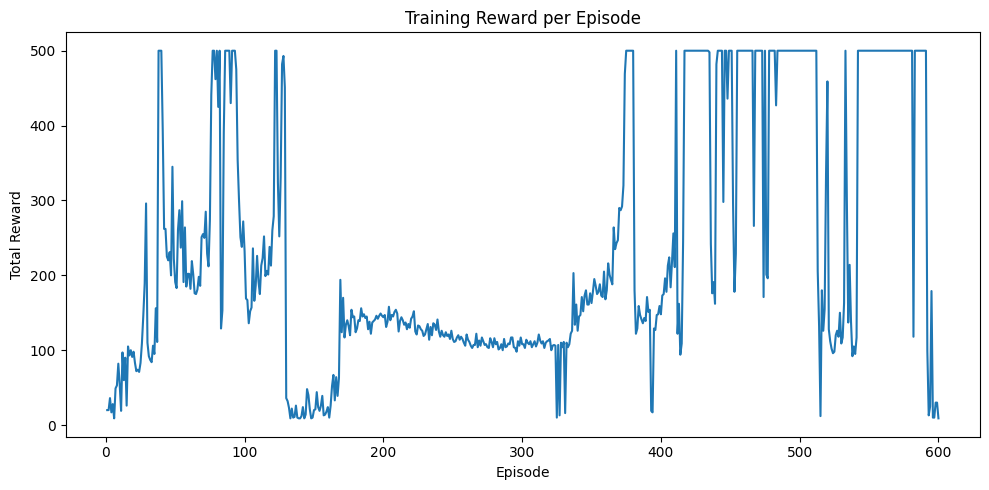

In [ ]:
d_agent.model.load_weights("checkpoints/testing_cartpole_dqn_weights_ravg.weights.h5")
best_weights = None
# best_weights = DQNTrain(d_agent, env, 600, 500)

In [35]:
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

weights_path = os.path.join(checkpoint_dir, "testing_cartpole_dqn_weights_ravg.weights.h5")
raw_weights_path = os.path.join(checkpoint_dir, "testing_cartpole_dqn_weights_raw.weights.h5")

d_agent.model.save_weights(raw_weights_path)

if best_weights is not None:
    d_agent.model.set_weights(best_weights)
    
d_agent.model.save_weights(weights_path)

### 2.3.5 Agent Evaluation

Evaluation Episode 1/100 -> Reward: 500.0
Evaluation Episode 2/100 -> Reward: 500.0
Evaluation Episode 3/100 -> Reward: 500.0
Evaluation Episode 4/100 -> Reward: 500.0
Evaluation Episode 5/100 -> Reward: 500.0
Evaluation Episode 6/100 -> Reward: 500.0
Evaluation Episode 7/100 -> Reward: 500.0
Evaluation Episode 8/100 -> Reward: 500.0
Evaluation Episode 9/100 -> Reward: 500.0
Evaluation Episode 10/100 -> Reward: 500.0
Evaluation Episode 11/100 -> Reward: 500.0
Evaluation Episode 12/100 -> Reward: 500.0
Evaluation Episode 13/100 -> Reward: 500.0
Evaluation Episode 14/100 -> Reward: 500.0
Evaluation Episode 15/100 -> Reward: 500.0
Evaluation Episode 16/100 -> Reward: 500.0
Evaluation Episode 17/100 -> Reward: 500.0
Evaluation Episode 18/100 -> Reward: 500.0
Evaluation Episode 19/100 -> Reward: 500.0
Evaluation Episode 20/100 -> Reward: 500.0
Evaluation Episode 21/100 -> Reward: 500.0
Evaluation Episode 22/100 -> Reward: 500.0
Evaluation Episode 23/100 -> Reward: 500.0
Evaluation Episode 2

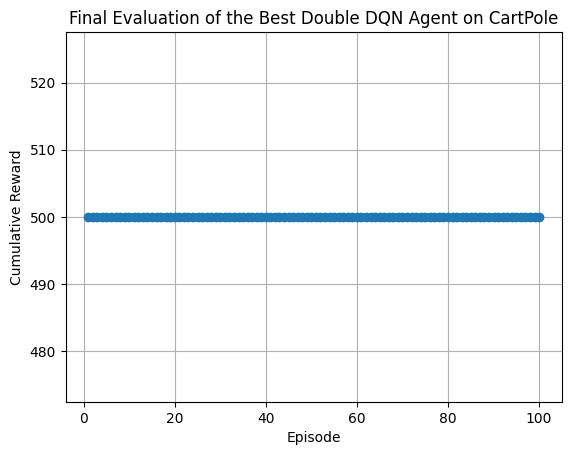

Average Reward over 100 evaluation episodes: 500.0


In [37]:
def d_evaluate_agent(agent, env, eval_episodes=100, max_time_steps=500):
    eval_rewards = []
     
    agent.epsilon = 0.0
    
    for i in range(eval_episodes):
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        done = False
        
        for _ in range(max_time_steps):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = np.reshape(next_state, [1, state_size])
            total_reward += reward
            if terminated or truncated:
                break
        
        eval_rewards.append(total_reward)
        print(f"Evaluation Episode {i+1}/{eval_episodes} -> Reward: {total_reward}")
    
    plt.plot(range(1, eval_episodes + 1), eval_rewards, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Final Evaluation of the Best Double DQN Agent on CartPole")
    plt.grid(True)
    plt.show()
    
    average_reward = np.mean(eval_rewards)
    print(f"Average Reward over {eval_episodes} evaluation episodes: {average_reward}")

d_evaluate_agent(d_agent, env)

### 3. Rendering an Episode

Objective:  
Render one full episode played by the trained agent and display it as an animation. This helps visually verify that the agent behaves correctly based on its learned policy.

---

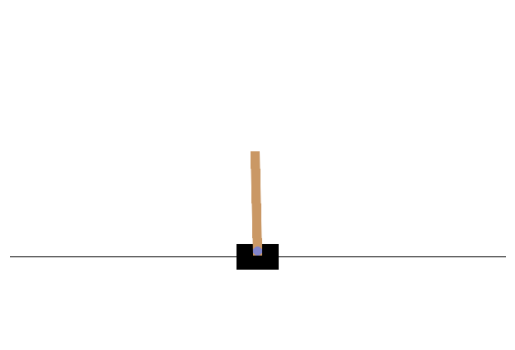

In [39]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
frames = []

state, _ = env.reset()
state = np.reshape(state, [1, state_size])
done = False
time_steps = 0

while not done:
    time_steps += 1
    frame = env.render()
    frames.append(frame)

    action = d_agent.act(state)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    state = np.reshape(next_state, [1, state_size])

env.close()

fig = plt.figure()
patch = plt.imshow(frames[0])  
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml(embed_frames=True, default_mode='loop'))

In [40]:
print(f"Total time steps: {time_steps}")

Total time steps: 500


## Conclusion

In this project, three reinforcement learning (RL) algorithms—Monte Carlo, Q-Learning, and Deep Q-Network (DQN) were implemented and compared in the CartPole-v1 environment. Each method demonstrated distinct strengths, limitations, and learning behaviors, offering valuable insights into policy learning in continuous state spaces.

---

### Summary of Methods

- Monte Carlo:  
  Leveraging first-visit returns and tabular updates, the Monte Carlo agent benefited from discretizing the continuous state space. While effective, it required many episodes to converge and was sensitive to binning granularity.

- Q-Learning:  
  A model-free, off-policy method that provided faster and more stable learning than Monte Carlo. Careful tuning of hyperparameters like learning rate decay and ε-scheduling led to robust performance, consistently surpassing the success threshold.

- Deep Q-Network (DQN):  
  By using a neural network to approximate Q-values, DQN removed the need for state discretization. With techniques like experience replay, target networks, and Double DQN, it achieved stable long-term learning and strong generalization.

---

### Summary

1. Discretization is essential in tabular methods but introduces a trade-off between resolution and generalization.
2. Exploration strategies, including ε-greedy policies and decay schedules, are critical for balancing learning efficiency and performance.
3. Model complexity impacts scalability—tabular methods are interpretable but limited; neural models are powerful but require more care in tuning and training.
4. Evaluation and Visualization confirmed that all agents, when tuned properly, could learn policies that solve the CartPole task consistently.

---

### Final Results

All three agents successfully solved the CartPole-v1 environment, consistently achieving average rewards exceeding 195. This progression from Monte Carlo to Q-Learning to DQN illustrates the evolution from simple value estimation to complex function approximation.

---

This project provided a comprehensive exploration of RL fundamentals and deepened understanding of how various algorithms approach the same task differently. These foundational concepts form a strong base for tackling more advanced RL challenges and applying them to real-world decision-making systems.
